# **Lab 4: Dataset Distillation**
by MBZUAI VILA Lab: https://github.com/VILA-Lab.


## Introduction

This colab notebook provides code and a framework for Lab 4: dataset distillation. In this lab, you will learn how to generate a small version of dataset from the original large one (i.e., recovering stage) based on the paper: "Squeeze, recover and relabel: Dataset condensation at imagenet scale from a new perspective." Advances in Neural Information Processing Systems (2023).

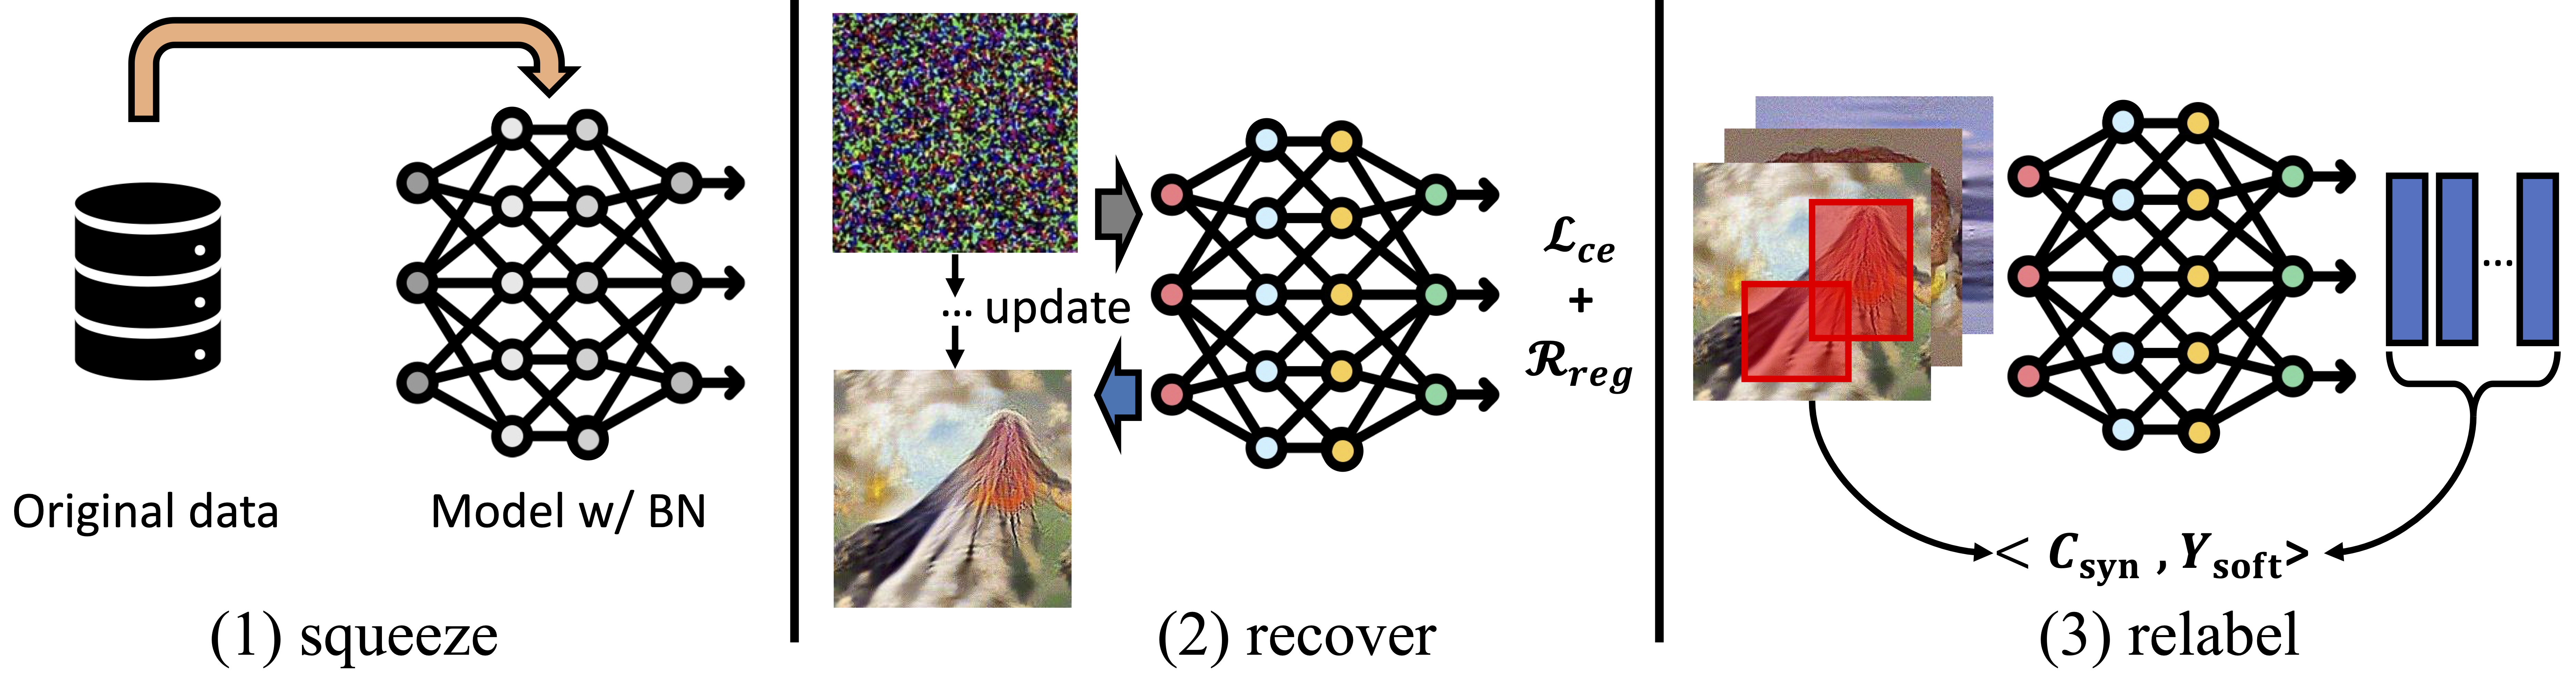

In [1]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
print(gpu_info)
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

import argparse
import collections
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data.distributed
from PIL import Image
# from utils import BNFeatureHook, lr_cosine_policy

Wed Sep 25 16:34:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:1D:00.0 Off |                  Off |
| 30%   35C    P8              30W / 300W |     10MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
class BNFeatureHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        nch = input[0].shape[1]
        mean = input[0].mean([0, 2, 3])
        var = input[0].permute(1, 0, 2, 3).contiguous().reshape([nch, -1]).var(1, unbiased=False)
        r_feature = torch.norm(module.running_var.data - var, 2) + torch.norm(module.running_mean.data - mean, 2)
        self.r_feature = r_feature

    def close(self):
        self.hook.remove()

In [3]:
def lr_cosine_policy(base_lr, warmup_length, epochs):
    def _lr_fn(iteration, epoch):
        if epoch < warmup_length:
            lr = base_lr * (epoch + 1) / warmup_length
        else:
            e = epoch - warmup_length
            es = epochs - warmup_length
            lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
        return lr

    return lr_policy(_lr_fn)


In [4]:
def lr_policy(lr_fn):
    def _alr(optimizer, iteration, epoch):
        lr = lr_fn(iteration, epoch)
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    return _alr

In [5]:
def clip_cifar(image_tensor):
    """
    adjust the input based on mean and variance for cifar
    """
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[:, c] = torch.clamp(image_tensor[:, c], -m / s, (1 - m) / s)
    return image_tensor

In [6]:
def denormalize_cifar(image_tensor):
    """
    convert floats back to input for cifar
    """
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])

    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[:, c] = torch.clamp(image_tensor[:, c] * s + m, 0, 1)

    return image_tensor


In [7]:
def save_images(args, images, targets, ipc_id):
    for id in range(images.shape[0]):
        if targets.ndimension() == 1:
            class_id = targets[id].item()
        else:
            class_id = targets[id].argmax().item()

        if not os.path.exists(args.syn_data_path):
            os.mkdir(args.syn_data_path)

        # save into separate folders
        dir_path = "{}/new{:03d}".format(args.syn_data_path, class_id)
        place_to_store = dir_path + "/class{:03d}_id{:03d}.jpg".format(class_id, ipc_id)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

        image_np = images[id].data.cpu().numpy().transpose((1, 2, 0))
        pil_image = Image.fromarray((image_np * 255).astype(np.uint8))
        pil_image.save(place_to_store)


### Question

Please complete the following function for calculating the cross-entropy and regularization losses.

In [9]:
def get_images(args, model_teacher, hook_for_display, ipc_id):
    print("get_images call")
    save_every = 100
    batch_size = args.batch_size
    best_cost = 1e4

    loss_r_feature_layers = []
    for module in model_teacher.modules():
        if isinstance(module, nn.BatchNorm2d):
            loss_r_feature_layers.append(BNFeatureHook(module))

    # setup target labels
    targets_all = torch.LongTensor(np.arange(100))

    for kk in range(0, 100, batch_size):
        targets = targets_all[kk : min(kk + batch_size, 100)].to("cuda")

        data_type = torch.float
        inputs = torch.randn((targets.shape[0], 3, 32, 32), requires_grad=True, device="cuda", dtype=data_type)

        iterations_per_layer = args.iteration
        lim_0, lim_1 = args.jitter, args.jitter

        optimizer = optim.Adam([inputs], lr=args.lr, betas=[0.5, 0.9], eps=1e-8)
        lr_scheduler = lr_cosine_policy(args.lr, 0, iterations_per_layer)  # 0 - do not use warmup
        criterion = nn.CrossEntropyLoss()
        criterion = criterion.cuda()

        for iteration in range(iterations_per_layer):
            # learning rate scheduling
            lr_scheduler(optimizer, iteration, iteration)

            # apply random jitter offsets
            off1 = random.randint(0, lim_0)
            off2 = random.randint(0, lim_1)
            inputs_jit = torch.roll(inputs, shifts=(off1, off2), dims=(2, 3))

            # forward pass
            optimizer.zero_grad()
            outputs = model_teacher(inputs_jit)

            # R_cross classification loss
            ############### YOUR CODE STARTS HERE ###############
            # hint: cross entropy loss between outputs and targets
            loss_ce = criterion(outputs, targets)
            ############### YOUR CODE ENDS HERE #################

            # R_feature loss
            rescale = [args.first_bn_multiplier] + [1.0 for _ in range(len(loss_r_feature_layers) - 1)]

            ############### YOUR CODE STARTS HERE ###############
            # hint: BN feature distribution regularization loss term across the whole network
            loss_r_bn_feature = [hook.r_feature * rescale[idx] for idx, hook in enumerate(loss_r_feature_layers)]
            ############### YOUR CODE ENDS HERE #################
            
            loss_r_bn_feature = torch.stack(loss_r_bn_feature).sum()

            loss_aux = args.r_bn * loss_r_bn_feature

            loss = loss_ce + loss_aux

            if iteration % save_every == 0 and args.verifier:
                print("------------iteration {}----------".format(iteration))
                print("loss_ce", loss_ce.item())
                print("loss_r_bn_feature", loss_r_bn_feature.item())
                print("loss_total", loss.item())
                # comment below line can speed up the training (no validation process)
                if hook_for_display is not None:
                    acc_jit, _ = hook_for_display(inputs_jit, targets)
                    acc_image, loss_image = hook_for_display(inputs, targets)

            # do image update
            loss.backward()
            optimizer.step()

            # clip color outlayers
            inputs.data = clip_cifar(inputs.data)

            if best_cost > loss.item() or iteration == 1:
                best_inputs = inputs.data.clone()

        if args.store_best_images:
            best_inputs = inputs.data.clone()  # using multicrop, save the last one
            best_inputs = denormalize_cifar(best_inputs)
            save_images(args, best_inputs, targets, ipc_id)

        # to reduce memory consumption by states of the optimizer we deallocate memory
        optimizer.state = collections.defaultdict(dict)

    torch.cuda.empty_cache()

In [10]:
def main_syn(args, ipc_id):
    if not os.path.exists(args.syn_data_path):
        os.makedirs(args.syn_data_path)

    # model_teacher = models.__dict__[args.arch_name](pretrained=True)

    import torchvision

    model_teacher = torchvision.models.get_model("resnet18", num_classes=100)
    model_teacher.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model_teacher.maxpool = nn.Identity()

    model_teacher = nn.DataParallel(model_teacher).cuda()

    checkpoint = torch.load(args.arch_path)
    model_teacher.load_state_dict(checkpoint["state_dict"])

    model_teacher.eval()
    for p in model_teacher.parameters():
        p.requires_grad = False

    hook_for_display = None
    get_images(args, model_teacher, hook_for_display, ipc_id)

In [11]:
parser = argparse.ArgumentParser("SRe2L: recover data from pre-trained model")
"""Data save flags"""
parser.add_argument(
    "--exp-name", type=str, default="test", help="name of the experiment, subfolder under syn_data_path"
)
parser.add_argument("--syn-data-path", type=str, default="./syn_data", help="where to store synthetic data")
parser.add_argument("--store-best-images", action="store_true", help="whether to store best images")
"""Optimization related flags"""
parser.add_argument("--batch-size", type=int, default=100, help="number of images to optimize at the same time")
parser.add_argument("--iteration", type=int, default=1000, help="num of iterations to optimize the synthetic data")
parser.add_argument("--lr", type=float, default=0.1, help="learning rate for optimization")
parser.add_argument("--jitter", default=4, type=int, help="random shift on the synthetic data")
parser.add_argument(
    "--r-bn", type=float, default=0.05, help="coefficient for BN feature distribution regularization"
)
parser.add_argument(
    "--first-bn-multiplier", type=float, default=10.0, help="additional multiplier on first bn layer of R_bn"
)
"""Model related flags"""
parser.add_argument(
    "--arch-name", type=str, default="resnet18", help="arch name from pretrained torchvision models"
)
parser.add_argument("--arch-path", type=str, default="cifar100/resnet18_E200/ckpt.pth")
parser.add_argument("--verifier", action="store_true", help="whether to evaluate synthetic data with another model")
parser.add_argument(
    "--verifier-arch",
    type=str,
    default="mobilenet_v2",
    help="arch name from torchvision models to act as a verifier",
)
parser.add_argument("--ipc-start", default=0, type=int)
parser.add_argument("--ipc-end", default=5, type=int)
args = parser.parse_args('')

args.syn_data_path = os.path.join(args.syn_data_path, args.exp_name)

print(args)



Namespace(exp_name='test', syn_data_path='./syn_data/test', store_best_images=False, batch_size=100, iteration=1000, lr=0.1, jitter=4, r_bn=0.05, first_bn_multiplier=10.0, arch_name='resnet18', arch_path='cifar100/resnet18_E200/ckpt.pth', verifier=False, verifier_arch='mobilenet_v2', ipc_start=0, ipc_end=5)



Download pretrained squeezing teacher mdoel of ResNet-18 at: https://drive.google.com/drive/folders/1nwZ2-LHWyyLuCGHJD8ntGy63_oTirpsm?usp=sharing. The path of the model (`--arch-path`) should be: `cifar100/resnet18_E200/ckpt.pth` on your local machine.

Start to generate data by running: 

In [13]:
# args = parse_args()
args.milestone = 1
args.store_best_images = True

for ipc_id in range(args.ipc_start, args.ipc_end):
    print("ipc = ", ipc_id)
    main_syn(args, ipc_id)

ipc =  0
get_images call
ipc =  1
get_images call
ipc =  2
get_images call
ipc =  3
get_images call
ipc =  4
get_images call


Check out the generation in the folder `./syn_data`.